In [28]:
# Load package
import os
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn-v0_8')
sns.set(font_scale=2) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image

In [29]:
# Data
df = pd.read_pickle("../datasets/LSWMD.pkl")
df.info()
#wafermap
#dieSize: 웨이퍼 내 개별 die 크기
#lotName: 웨이퍼가 속한 생성 배치(lot)의 이름
#waferIndex: 한 lot 안에서도 wafer의 위치를 나타낼 수 있음
#trainTestLabel: 훈련,테스트 데이터셋 중 어느 그룹에 속하는지 나타냄
#failuerType: 웨이퍼 결함 유형을 나타냄
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


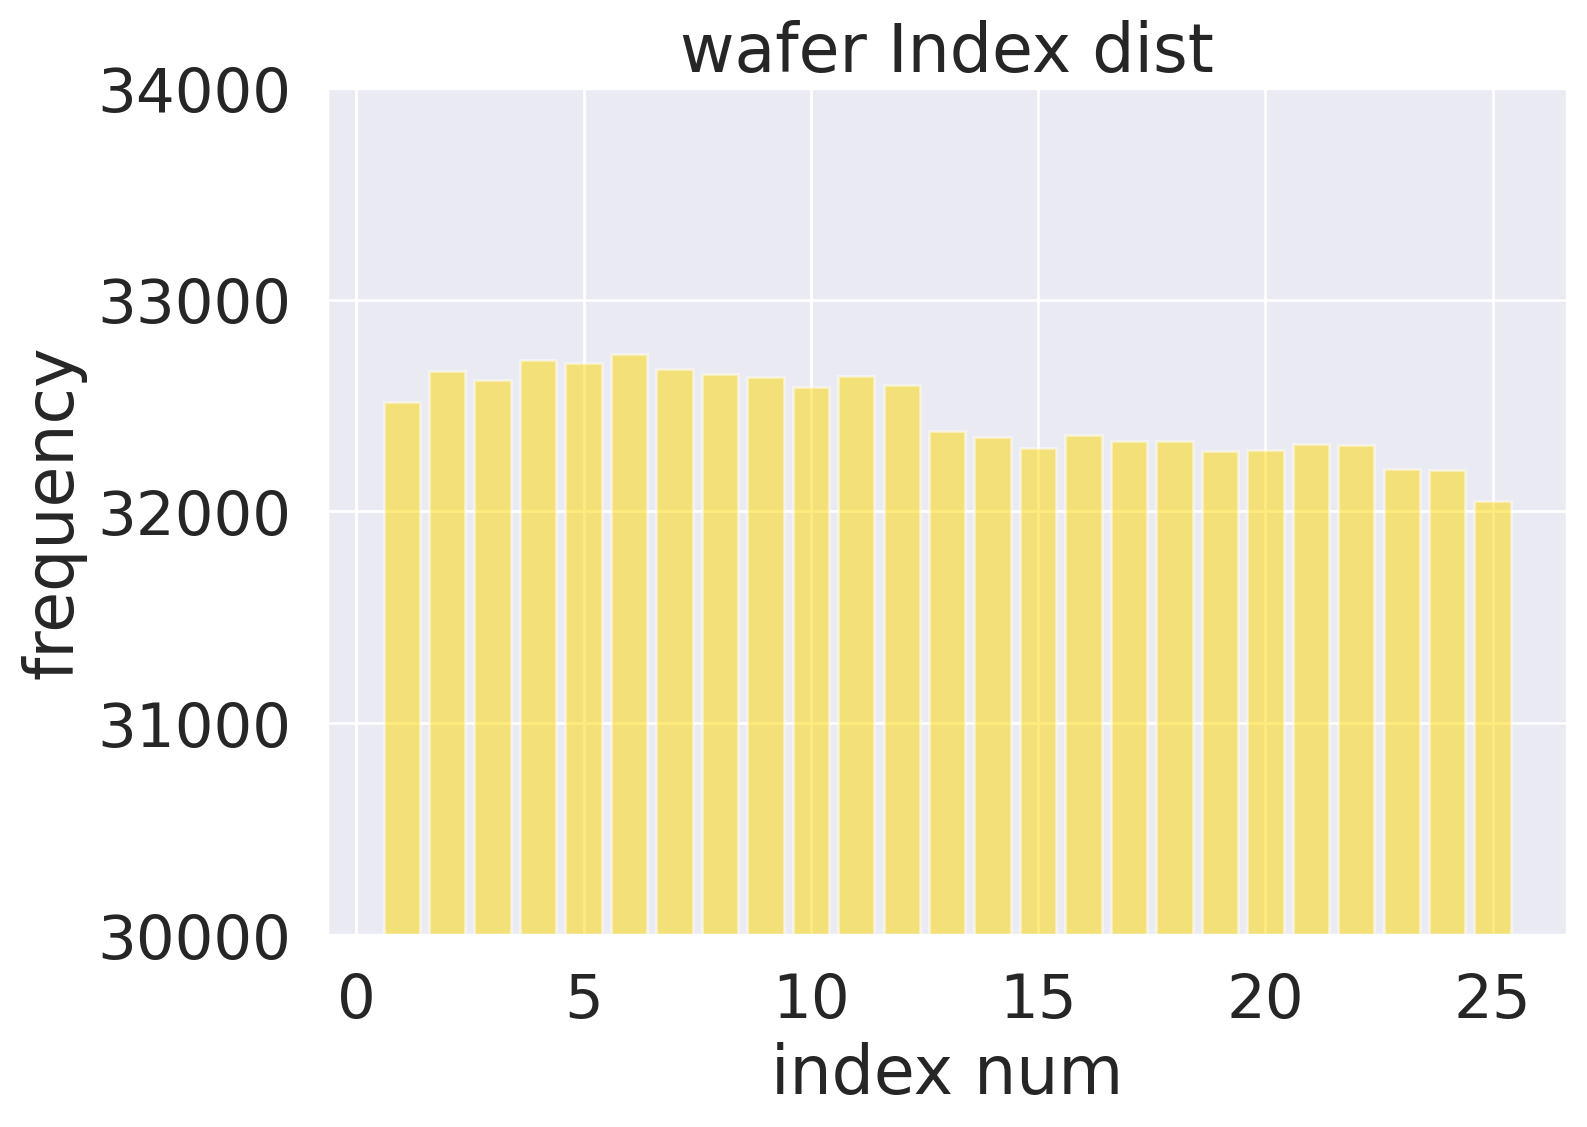

In [30]:
# 1. The distribution of lot_idx and num_wafer
lot_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(lot_index[0], lot_index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index dist")
plt.xlabel("index num")
plt.ylabel("frequency")
plt.ylim(30000, 34000)
plt.show()

In [31]:
# Drop column
df = df.drop(['waferIndex'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
dtypes: float64(1), object(4)
memory usage: 31.0+ MB


In [32]:
# 2. Add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']= df['waferMap'].apply(lambda x: find_dim(x))
df.head(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [33]:
# 3. To check failureType distribution and encoding label
df['failureNum'] = df['failureType']
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df = df.replace({'failureNum':mapping_type})
df.head(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8


In [34]:
# df_withlabel : 결함이 있는 웨이퍼만 선택
# df_withpattern : labeled & patterned wafer : 결함에서 특정 패턴이 나타나는 웨이퍼만 선택
# df_nonpatter : labeled but non-patterned wafer : 결함에서 아무런 패턴도 나타나지 않는 웨이퍼만 선택
df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.
df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] #nonpatterned index
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] # 위 각 웨이퍼 수 : A = B + C

(172950, 25519, 147431)

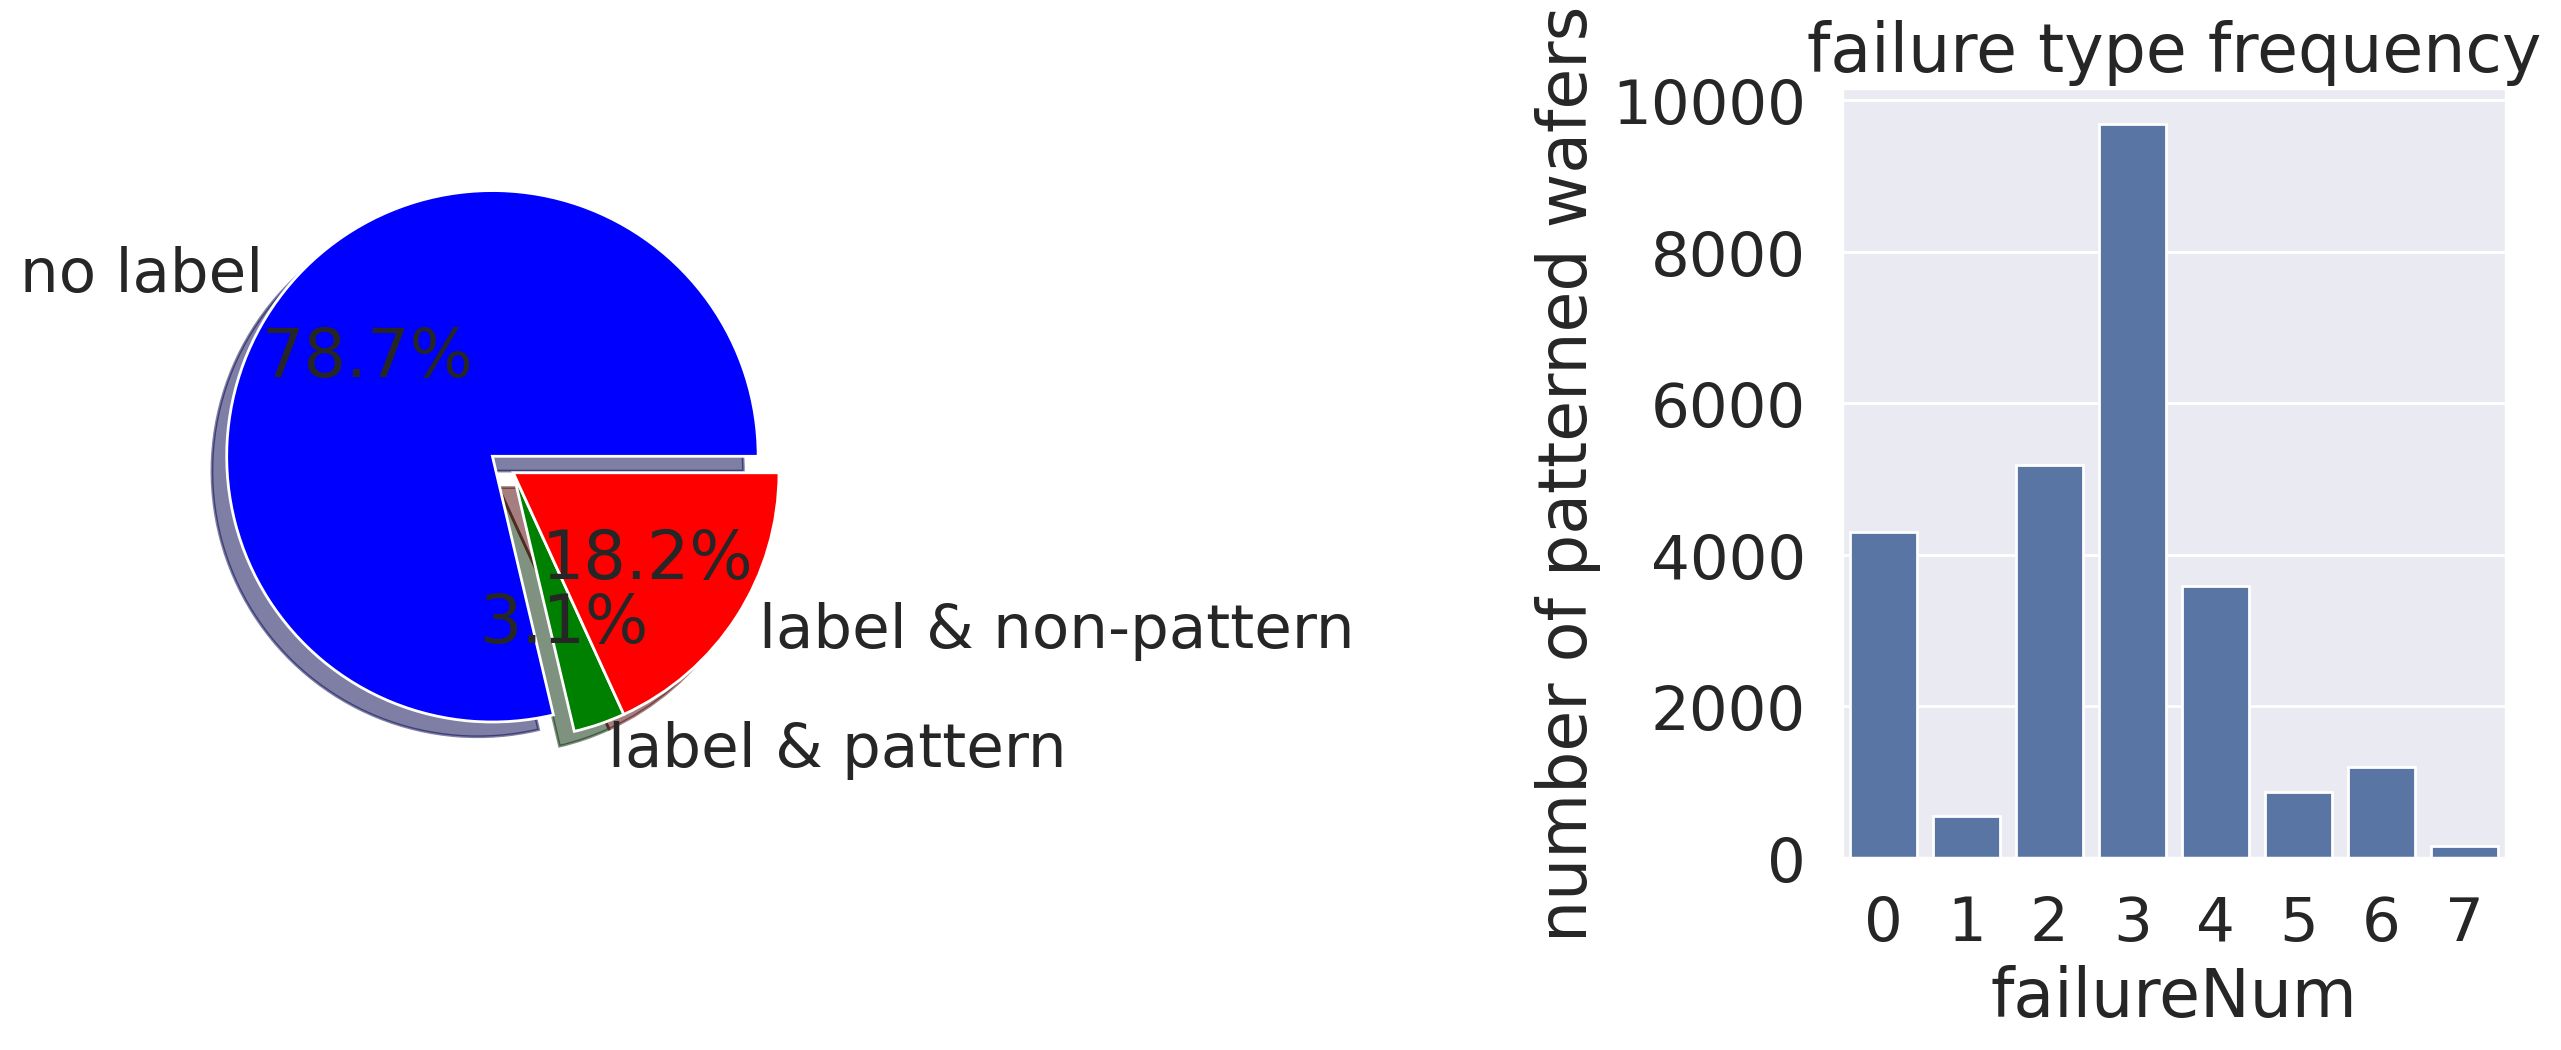

In [35]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
colors = ['blue', 'green', 'red']
num_wafers=[len(df['waferMap'])-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]
labels = ['no label', 'label & pattern', 'label & non-pattern']
ax[0].pie(num_wafers, explode=(0.1,0,0), labels = labels, colors = colors, autopct = '%1.1f%%', shadow=True)
sns.countplot(x='failureNum', data=df_withpattern, ax=ax[1])
ax[1].set_title("failure type frequency")
ax[1].set_ylabel("number of patterned wafers")
plt.subplots_adjust(wspace = 1.5)
plt.show()

In [36]:
df_withlabel['waferMapDim'].value_counts() # 이걸 왜 하는지는 잘 모르겟네?

waferMapDim
(25, 27)      18781
(26, 26)      14366
(30, 34)      12400
(29, 26)      11751
(27, 25)      10682
              ...  
(71, 72)          1
(64, 61)          1
(122, 102)        1
(75, 77)          1
(67, 65)          1
Name: count, Length: 346, dtype: int64

In [37]:
# Extract (25,27) & (26,26) waferMapDim data
def subwafer(sw,label):
    Dim0 = np.size(sw, axis=1)
    Dim1 = np.size(sw, axis=2)
    sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (Dim0, Dim1)] #sub_df에는 waferMapDim이 (25,27) 또는 (26,26)인 행만 저장됨
    sub_wafer = sub_df['waferMap'].values 
    sw = sw.to(torch.device('cuda'))
    for i in range(len(sub_df)):
        waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1)) # 이 시점에서 패턴이 없는 웨이퍼는 필터링되면서 제외됨
        waferMap = waferMap.to(torch.device('cuda'))
        sw = torch.cat([sw, waferMap])
        label.append(sub_df.iloc[i,:]['failureType'][0][0])
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    del waferMap, sw
    return x, y # x: 웨이퍼 맵 데이터, y: 결함 유형(numpy 배열)

sw0 = torch.ones((1, 25, 27))
sw1 = torch.ones((1, 26, 26))
label0 = list()
label1 = list()
x0, y0 = subwafer(sw0, label0)
x1, y1 = subwafer(sw1, label1)
x0.shape, x1.shape, y0.shape, y1.shape


(torch.Size([18781, 25, 27]),
 torch.Size([14366, 26, 26]),
 (18781, 1),
 (14366, 1))

In [38]:
# Add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B

def rgb_sw(x):
    Dim0 = np.size(x, axis=1)
    Dim1 = np.size(x, axis=2)
    new_x = np.zeros((len(x), Dim0, Dim1, 3))
    x = torch.unsqueeze(x,-1)
    x = x.to(torch.device('cpu'))
    x = x.numpy()
    for w in range(len(x)): 
        for i in range(Dim0):
            for j in range(Dim1):
                new_x[w, i, j, int(x[w, i, j].item())] = 1
    return new_x

rgb_x0 = rgb_sw(x0)
rgb_x1 = rgb_sw(x1)

rgb_x0.shape, rgb_x1.shape

((18781, 25, 27, 3), (14366, 26, 26, 3))

In [39]:
#To use two dim, we have to resize these data.
def resize(x):
    rwm = torch.ones((1,56,56,3))
    for i in range(len(x)):
        rwm = rwm.to(torch.device('cuda'))
        a = Image.fromarray(x[i].astype('uint8')).resize((56,56))
        a = np.array(a).reshape((1,56,56,3))
        a = torch.from_numpy(a)
        a = a.to(torch.device('cuda'))
        rwm = torch.cat([rwm, a])
    x = rwm[1:]
    del rwm
    return x

resized_x0 = resize(rgb_x0)
resized_x1 = resize(rgb_x1)

resized_x0.shape, resized_x1.shape

(torch.Size([18781, 56, 56, 3]), torch.Size([14366, 56, 56, 3]))

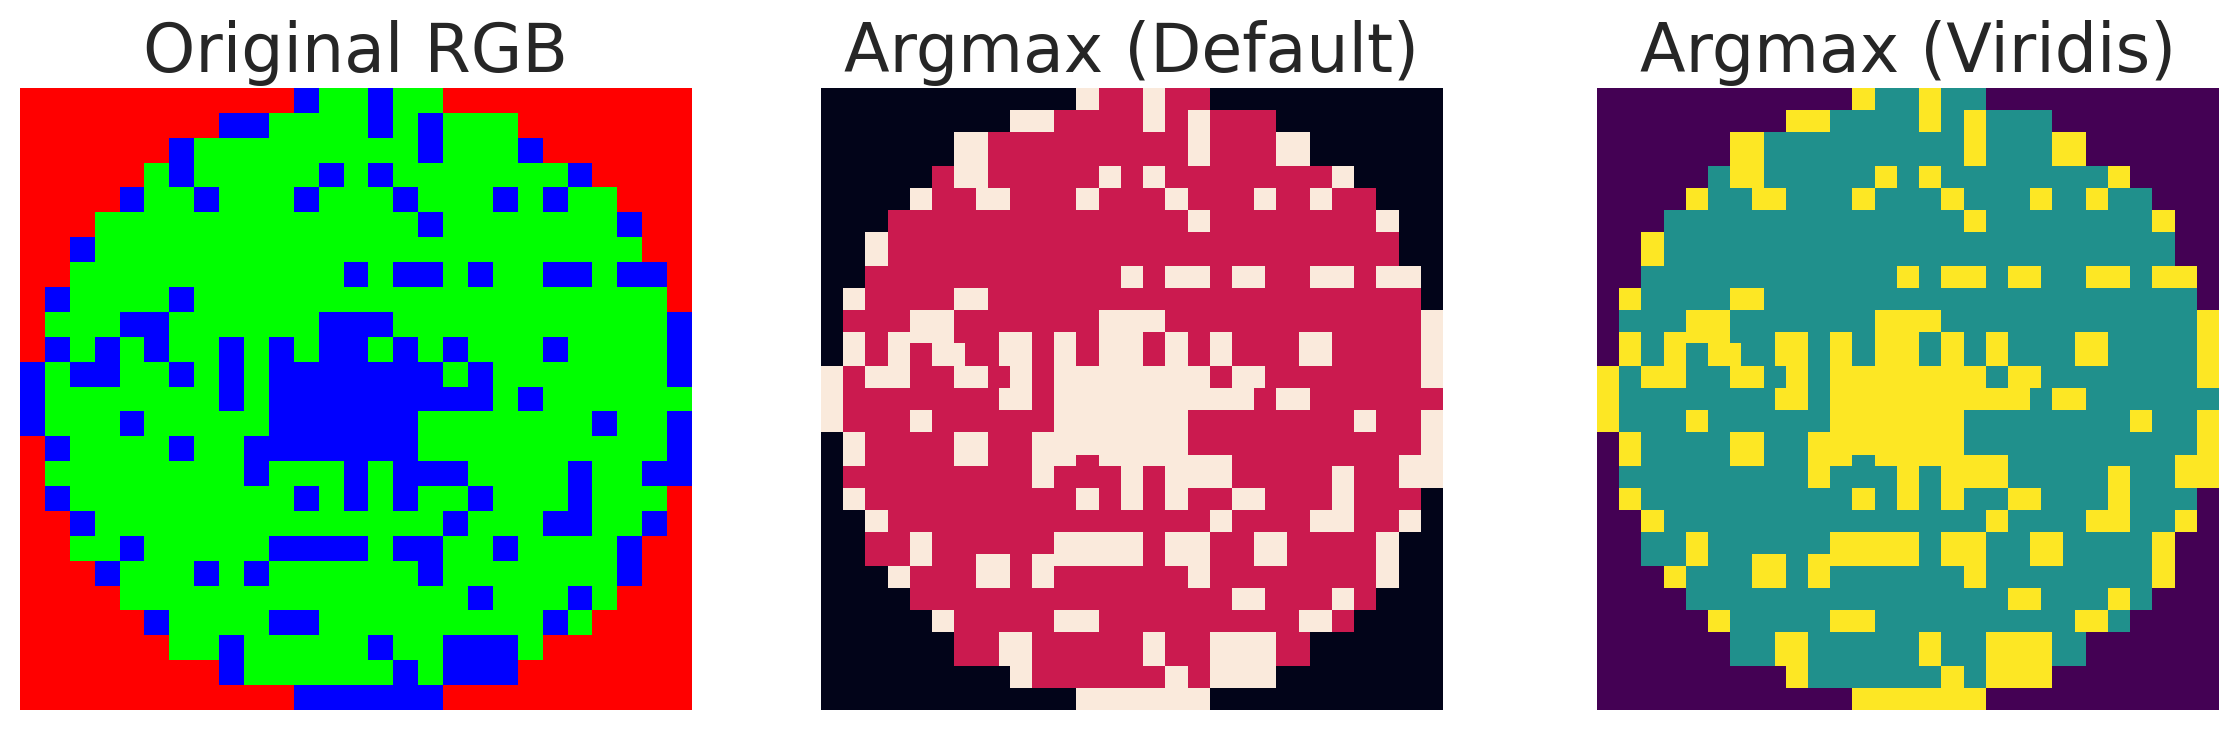

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1행 3열, 크기 조정

# 1️⃣ 원본 RGB 이미지
axes[0].imshow(rgb_x0[1000])
axes[0].set_title("Original RGB")
axes[0].axis('off')

# 2️⃣ One-Hot Encoding에서 변환된 인덱스 맵
axes[1].imshow(torch.argmax(resized_x0[1000], axis=2).cpu().numpy())
axes[1].set_title("Argmax (Default)")
axes[1].axis('off')

# 3️⃣ `viridis` 컬러맵 적용된 최종 이미지
axes[2].imshow(torch.argmax(resized_x0[1000], axis=2).cpu().numpy(), cmap='viridis')
axes[2].set_title("Argmax (Viridis)")
axes[2].axis('off')

plt.tight_layout()  # 간격 조정
plt.show()

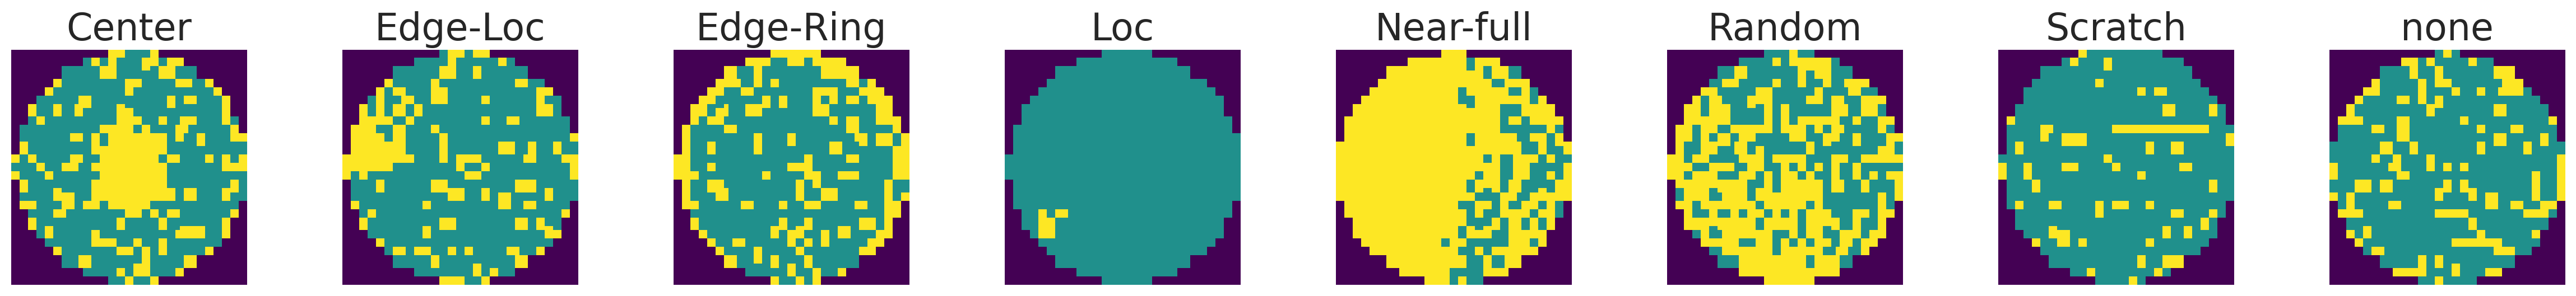

In [41]:
unique_labels = np.unique(y0)  # y0에서 유니크한 결함 유형 추출
num_labels = len(unique_labels)
# ✅ 서브플롯 생성 (1행 N열, N은 라벨 개수)
fig, axes = plt.subplots(1, num_labels, figsize=(num_labels * 3, 3)) 

# ✅ 각 Failure Type별로 하나씩 이미지 출력
for i, (label, ax) in enumerate(zip(unique_labels, axes.flat)):
    # 해당 Failure Type에 해당하는 첫 번째 샘플 선택
    wafer_idx = np.where(y0 == label)[0][0]  # y0에서 해당 라벨의 첫 번째 인덱스 찾기
    wafer_map = torch.argmax(resized_x0[wafer_idx], axis=2).cpu().numpy()  # One-Hot → 2D 변환

    # 이미지 출력
    ax.imshow(wafer_map, cmap='viridis')
    ax.set_title(label)
    ax.axis('off')  # 축 제거

plt.tight_layout()  # 간격 조정
plt.show()

In [42]:
# Concatenate all data together
resized_wm = torch.cat([resized_x0, resized_x1])
label_wm = np.concatenate((y0, y1))

resized_wm.shape, label_wm.shape

(torch.Size([33147, 56, 56, 3]), (33147, 1))

In [43]:
# parameters
args = {'BATCH_SIZE': 16,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

In [44]:
USE_CUDA = torch.cuda.is_available()


In [45]:
# dataloader for autoencoder
resized_wm = resized_wm.permute(0,3,1,2) #CNN 모델이 요구하는 데이터 모양으로 맞춰줘야 하기 때문
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
train_loader  = torch.utils.data.DataLoader(resized_wm, args['BATCH_SIZE'], shuffle=True)
resized_wm.shape, label_wm.shape

(torch.Size([33147, 3, 56, 56]), (33147, 1))

In [46]:
# delete data
del y0,y1,resized_x0, resized_x1
del rgb_x0, rgb_x1
del x0, x1

In [47]:
# AutoEncoder Model

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                                             nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                                             nn.Sigmoid())
            
    def encoder(self, x):
        encode = self.cnn_layer1(x)
        encode = self.cnn_layer2(encode)   
        return encode
    
    def decoder(self, x):
        decode = self.tran_cnn_layer1(x)
        decode = self.tran_cnn_layer2(decode)
        return decode

    def forward(self, x):
        output = self.encoder(x)
        output = self.decoder(output)
        return output

In [48]:
# Setup Model, loss_func, optimizer
model = ConvAutoEncoder().to(DEVICE)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [49]:
from torchsummary import summary
summary(model,(3,54,54), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 54, 54]             448
              ReLU-2           [16, 16, 54, 54]               0
         MaxPool2d-3           [16, 16, 27, 27]               0
            Conv2d-4           [16, 32, 27, 27]           4,640
              ReLU-5           [16, 32, 27, 27]               0
         MaxPool2d-6           [16, 32, 13, 13]               0
   ConvTranspose2d-7           [16, 16, 26, 26]           2,064
              ReLU-8           [16, 16, 26, 26]               0
   ConvTranspose2d-9            [16, 3, 52, 52]             195
          Sigmoid-10            [16, 3, 52, 52]               0
Total params: 7,347
Trainable params: 7,347
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.53
Forward/backward pass size (MB): 23.79
Params size (MB): 0.03
Estimated Tota

In [50]:
steps = 0
print(resized_wm.shape)
total_steps = len(train_loader)
losses = []
iterations = []
save_path = "./saved_models"  # 모델 저장 폴더 경로

# 모델 저장 디렉토리 생성 (없으면 생성)
os.makedirs(save_path, exist_ok=True)

for epoch in range(args['NUM_EPOCH']+20):    
    running_loss = 0.0
    for i, wafer in enumerate(train_loader):
        steps += 1
        wafer = wafer.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(wafer)
        loss = criterion(outputs, wafer)  # Autoencoder loss: 입력과 출력 비교
        loss.backward()
        running_loss += loss.item() * wafer.shape[0]
        optimizer.step()

        if steps % total_steps == 0:
            model.eval()
            avg_loss = running_loss / total_steps
            print(f"Epoch: {epoch+1}/{args['NUM_EPOCH']} => Loss: {avg_loss:.3f}")
            steps = 0
            iterations.append(i)
            losses.append(avg_loss)
            model.train()

    #매 10번째 에폭마다 모델 저장
    if (epoch + 1) % 10 == 0:
        model_filename = os.path.join(save_path, f"autoencoder_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), model_filename)
        print(f"Model Saved: {model_filename}")

print("Training Complete!")


torch.Size([33147, 3, 56, 56])
Epoch: 1/10 => Loss: 0.499
Epoch: 2/10 => Loss: 0.138
Epoch: 3/10 => Loss: 0.096
Epoch: 4/10 => Loss: 0.080
Epoch: 5/10 => Loss: 0.071
Epoch: 6/10 => Loss: 0.066
Epoch: 7/10 => Loss: 0.062
Epoch: 8/10 => Loss: 0.059
Epoch: 9/10 => Loss: 0.056
Epoch: 10/10 => Loss: 0.053
Model Saved: ./saved_models/autoencoder_epoch10.pth
Epoch: 11/10 => Loss: 0.051
Epoch: 12/10 => Loss: 0.049
Epoch: 13/10 => Loss: 0.048
Epoch: 14/10 => Loss: 0.047
Epoch: 15/10 => Loss: 0.045
Epoch: 16/10 => Loss: 0.044
Epoch: 17/10 => Loss: 0.043
Epoch: 18/10 => Loss: 0.042
Epoch: 19/10 => Loss: 0.042
Epoch: 20/10 => Loss: 0.041
Model Saved: ./saved_models/autoencoder_epoch20.pth
Epoch: 21/10 => Loss: 0.040
Epoch: 22/10 => Loss: 0.040
Epoch: 23/10 => Loss: 0.039
Epoch: 24/10 => Loss: 0.039
Epoch: 25/10 => Loss: 0.038
Epoch: 26/10 => Loss: 0.038
Epoch: 27/10 => Loss: 0.037
Epoch: 28/10 => Loss: 0.037
Epoch: 29/10 => Loss: 0.037
Epoch: 30/10 => Loss: 0.036
Model Saved: ./saved_models/autoen

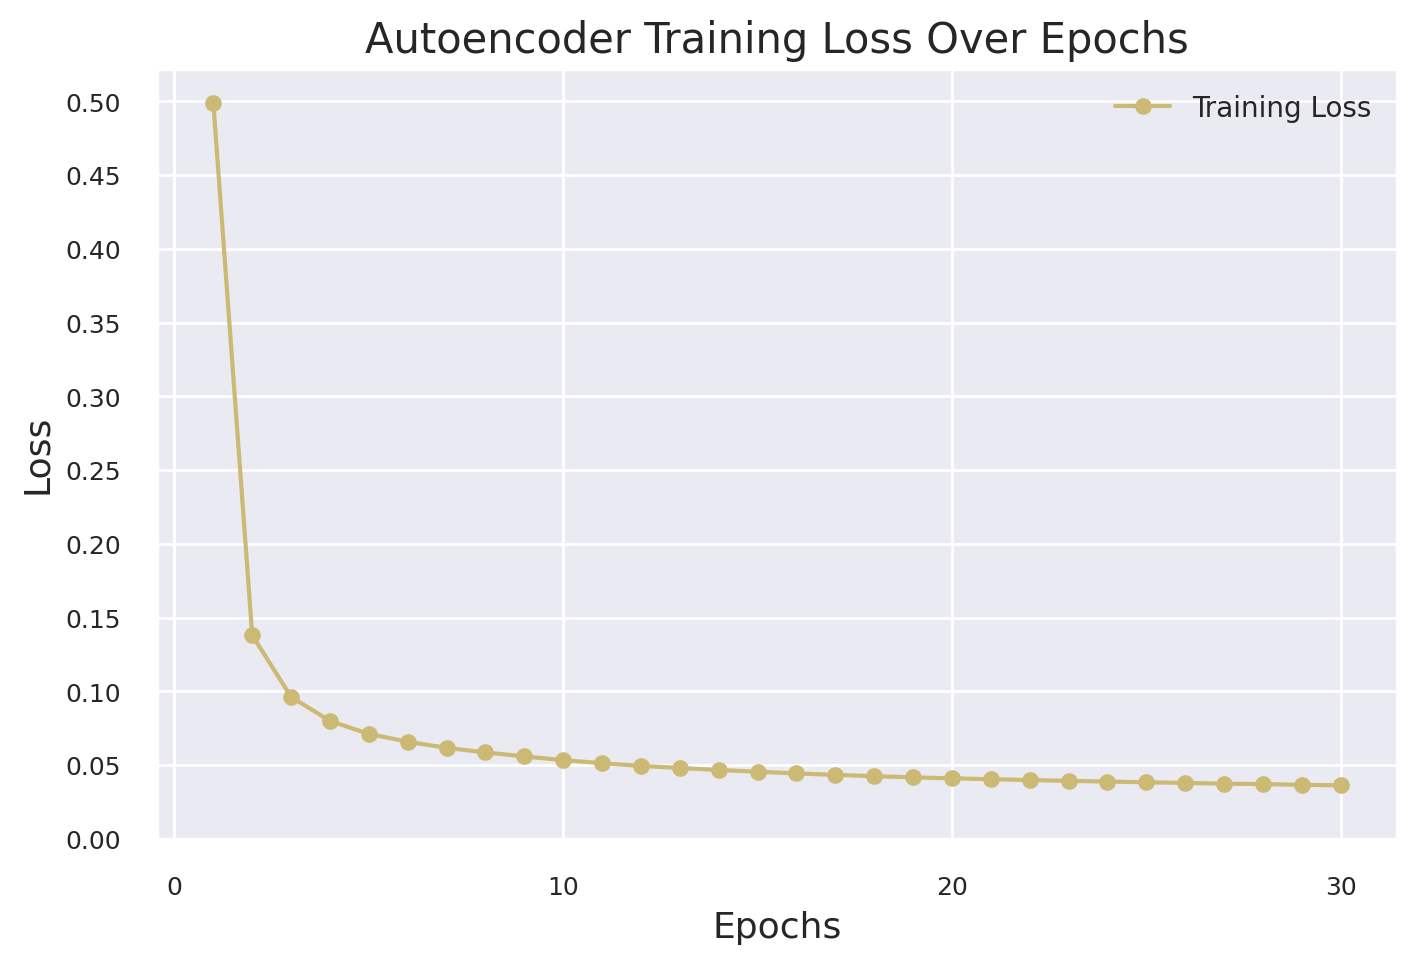

In [71]:
# ✅ 모든 에폭 리스트 생성
epochs = list(range(1, args['NUM_EPOCH'] + 21))  # 1부터 마지막 에폭까지 모든 값 포함

# ✅ 손실 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='y', label="Training Loss")

# ✅ 축 레이블, 제목, 범례의 글씨 크기 조정
plt.xlabel("Epochs", fontsize=13)  # x축 글씨 크기 조정
plt.ylabel("Loss", fontsize=13)  # y축 글씨 크기 조정
plt.title("Autoencoder Training Loss Over Epochs", fontsize=15)  # 제목 글씨 크기 조정
plt.legend(fontsize=10)  # 범례 글씨 크기 조정
plt.grid(True)

# ✅ y축 눈금을 0.05 단위로 설정
y_min, y_max = 0,0.5
plt.yticks(np.arange(y_min, y_max + 0.05, 0.05), fontsize = 9)  # 0.05 단위로 y축 눈금 
plt.xticks(fontsize = 9)

plt.show()